In [34]:
import pandas as pd
import random
import plotly.graph_objects as go
import plotly.express as px
import yaml
import os
import datetime as dt

(link to dataset)[https://dataverse.harvard.edu/dataset.xhtml?id=3047332]

In [2]:
tweets_df = pd.read_csv('./top-20-tweets-2017.csv')

In [3]:
tweets_df.shape

(52542, 10)

In [4]:
tweets_df.dtypes

author               object
content              object
country              object
date_time            object
id                  float64
language             object
latitude            float64
longitude           float64
number_of_likes       int64
number_of_shares      int64
dtype: object

In [5]:
print(
    tweets_df.date_time.min()
    , tweets_df.date_time.max()
)

01/01/2011 02:16 31/12/2016 23:59


In [6]:
tweets_df.sample(10)

author                                            content country  \
49110    instagram  The Week on Instagram | 238\r\nhttps://t.co/t1...     NaN   
32042    Cristiano                      👍⚽️✌️ https://t.co/tWz9mxmKBK     NaN   
12911      YouTube  On the 12th day of Christmas #12DeadlyDays gav...     NaN   
10615      rihanna                                Yessss sexy #7 FIFA     NaN   
17637     ladygaga  Thanku @SKstudly 4 the stunning photos you too...     NaN   
45687      shakira  Incredible! 600m views! / Increíble! 600 millo...     NaN   
7994   BarackObama  "When the cynics tell us we can't change this ...     NaN   
24333  jtimberlake  Iceland, you're beautiful. Everyone- you can s...     NaN   
15335      YouTube                     @JacobWhitesides Cannot. Wait.     NaN   
25596  jtimberlake  "@ebsamuels88: @jtimberlake what do you recomm...     NaN   

              date_time            id language  latitude  longitude  \
49110  04/06/2016 22:35  7.392240e+17       en       NaN        NaN   
32042  26/02/2016 15:12  7.032360e+17      und       NaN        NaN   
12911  22/12/2016 21:03  8.120410e+17       en       NaN        NaN   
10615  26/06/2014 16:05  4.821930e+17       en       NaN        NaN   
17637  29/09/2014 22:00  5.167090e+17       en       NaN        NaN   
45687  11/11/2015 21:56  6.645620e+17       es       NaN        NaN   
7994   09/11/2015 22:06  6.638400e+17       en       NaN        NaN   
24333  24/08/2014 18:50  5.036150e+17       en       NaN        NaN   
15335  11/02/2016 23:02  6.979190e+17       en       NaN        NaN   
25596  06/05/2012 18:07  1.991990e+17       en       NaN        NaN   

       number_of_likes  number_of_shares  
49110              828               197  
32042            15574              4068  
12911              694               104  
10615             5287              3472  
17637             4535              2949  
45687             1669               721  
7994              2686               935  
24333             5134              3128  
15335              228                84  
25596               51                50

In [7]:
tweets_df.author.unique()

array(['katyperry', 'justinbieber', 'taylorswift13', 'BarackObama',
       'rihanna', 'YouTube', 'ladygaga', 'TheEllenShow', 'Twitter',
       'jtimberlake', 'KimKardashian', 'britneyspears', 'Cristiano',
       'selenagomez', 'cnnbrk', 'jimmyfallon', 'ArianaGrande', 'shakira',
       'instagram', 'ddlovato'], dtype=object)

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [9]:
sample_tweets = tweets_df.content.sample(1000).values
sample_scores = []
for tweet in sample_tweets:
    sample_scores.append(analyser.polarity_scores(tweet))
    
df = pd.DataFrame(data = {'tweet': sample_tweets, 'vader_score': sample_scores})
df['sample_compound_score'] = df.vader_score.apply(lambda x: x['compound'])
    

In [10]:
tweets_df['vader_score'] = tweets_df.content.apply(lambda x: analyser.polarity_scores(x))

In [11]:
tweets_df['compound_score'] = tweets_df.vader_score.apply(lambda x: x['compound'])
tweets_df['datetime'] = pd.to_datetime(tweets_df.date_time)
    

In [12]:
## is it really this easy to just get the happiness lexicon from the hedonometer
import requests


r = requests.get("http://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2")

In [13]:
import json

json_data = json.loads(r.text)

In [14]:
# create hedonometer dict
hed_dict = {}

for obj in json_data['objects']:
    hed_dict[obj['word']] = obj

In [15]:
# random sample of hed_dict
keys = random.sample(list(hed_dict),10)

for k in keys:
    print(k, hed_dict[k])

lotta {'happs': 5.19, 'rank': 6278, 'stdDev': 1.43, 'text': 'lotta', 'word': 'lotta', 'word_english': 'lotta', 'wordlist': {'date': '2020-03-28', 'language': 'en', 'reference': 'https://arxiv.org/abs/2003.12614', 'referencetitle': "How the world's collective attention is being paid to a pandemic: COVID-19 related 1-gram time series for 24 languages on Twitter", 'title': 'labMT-en-v2'}}
sentences {'happs': 5.59, 'rank': 4340, 'stdDev': 1.63, 'text': 'sentences', 'word': 'sentences', 'word_english': 'sentences', 'wordlist': {'date': '2020-03-28', 'language': 'en', 'reference': 'https://arxiv.org/abs/2003.12614', 'referencetitle': "How the world's collective attention is being paid to a pandemic: COVID-19 related 1-gram time series for 24 languages on Twitter", 'title': 'labMT-en-v2'}}
subsidiary {'happs': 4.9, 'rank': 7637, 'stdDev': 1.4, 'text': 'subsidiary', 'word': 'subsidiary', 'word_english': 'subsidiary', 'wordlist': {'date': '2020-03-28', 'language': 'en', 'reference': 'https://ar

In [16]:
# clean words are words defined in hednometer lexicon
def get_word_ct(x, dict, tune_delta=None):
    res = []
    for wrd in str(x).split():
        if wrd.lower() in dict.keys():
            if tune_delta:
                if abs(dict[wrd.lower()]['happs'] - 5) > tune_delta:
                    res.append(wrd)
            else:
                res.append(wrd)
                    
    return len(res)
    
# get sum of clean word scores
def get_total_word_score(x, dict, tune_delta=None):
    res = []
    for wrd in str(x).split():
        if wrd.lower() in dict.keys():
            if tune_delta:
                if abs(dict[wrd.lower()]['happs'] - 5) > tune_delta:
                    res.append(dict[wrd.lower()]['happs'])
            else:
                res.append(dict[wrd.lower()]['happs'])
                    
    return sum(res)
    

# delta 1
tweets_df['hedonometer_word_count'] = tweets_df.content.apply(lambda x: get_word_ct(x, hed_dict,1))
tweets_df['hedonometer_total_score'] = tweets_df.content.apply(lambda x: get_total_word_score(x, hed_dict,1))
tweets_df['hedonometer_score'] = tweets_df.hedonometer_total_score/tweets_df.hedonometer_word_count

tweets_df.iloc[random.sample(range(100),1)]

author                                            content country  \
16  katyperry  Love the music therapy program at CHLA! https:...     NaN   

           date_time            id language  latitude  longitude  \
16  21/12/2016 22:42  8.117030e+17       en       NaN        NaN   

    number_of_likes  number_of_shares  \
16            11266              3064   

                                          vader_score  compound_score  \
16  {'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'comp...          0.6696   

              datetime  hedonometer_word_count  hedonometer_total_score  \
16 2016-12-21 22:42:00                       2                    16.44   

    hedonometer_score  
16               8.22

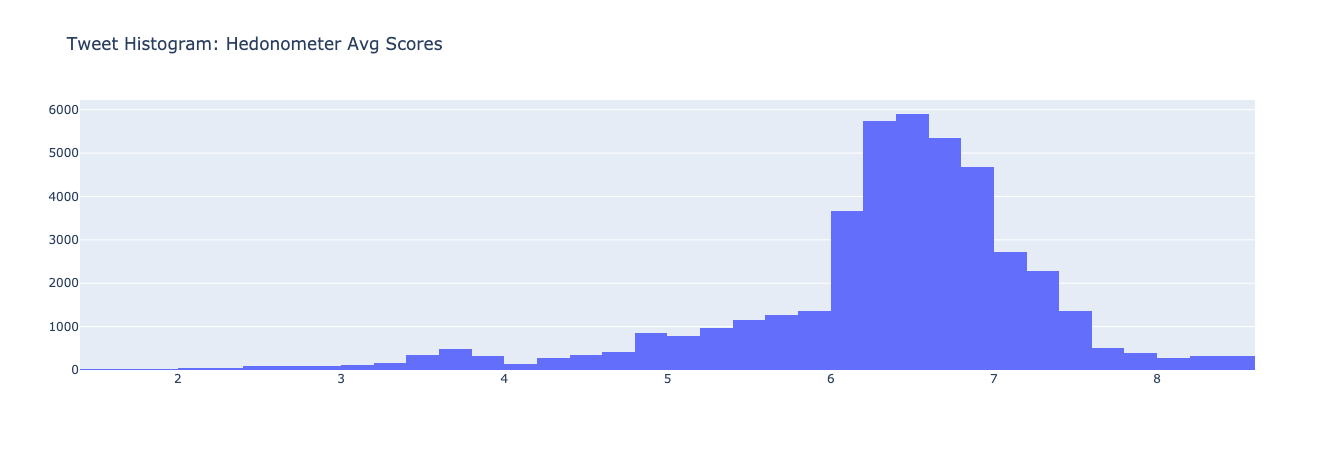

In [17]:
# histogram of hedonometer tweet scores without tuning 
fig = go.Figure({'data':[
    go.Histogram(x=tweets_df['hedonometer_score'], nbinsx=50)
]
                , 'layout': {"title": {"text": "Tweet Histogram: Hedonometer Avg Scores"}}
                }  
               )
fig.show()

In [18]:
### happiness vs sentiment in 2015
hed_score_adj = 5
tweets_df['compound_score_adj'] = tweets_df.compound_score.apply(lambda x: x * hed_score_adj + hed_score_adj)

by_day_df = tweets_df[tweets_df.datetime.dt.year==2015].groupby(tweets_df.datetime.dt.date).agg(
    {
        'hedonometer_score': 'mean'
        , 'compound_score_adj': 'mean'
    }
)

by_day_df.head(20)

hedonometer_score  compound_score_adj
datetime                                         
2015-01-01           6.494567            6.719018
2015-01-02           6.427381            6.749382
2015-01-03           6.357218            6.959031
2015-01-04           6.462773            6.180159
2015-01-05           6.656369            6.590885
2015-01-06           6.308752            6.673330
2015-01-07           6.630154            6.715455
2015-01-08           6.735419            6.635379
2015-01-09           6.350026            6.376794
2015-01-10           6.559990            6.440500
2015-01-11           6.448006            6.908140
2015-01-12           6.334423            6.565991
2015-01-13           6.145639            6.816395
2015-01-14           6.000867            5.397528
2015-01-15           6.316282            5.969038
2015-01-16           6.484418            5.954105
2015-01-17           6.429051            6.486067
2015-01-18           6.484528            6.299068
2015-01-19           6.147526            6.304675
2015-01-20           6.189374            6.562468

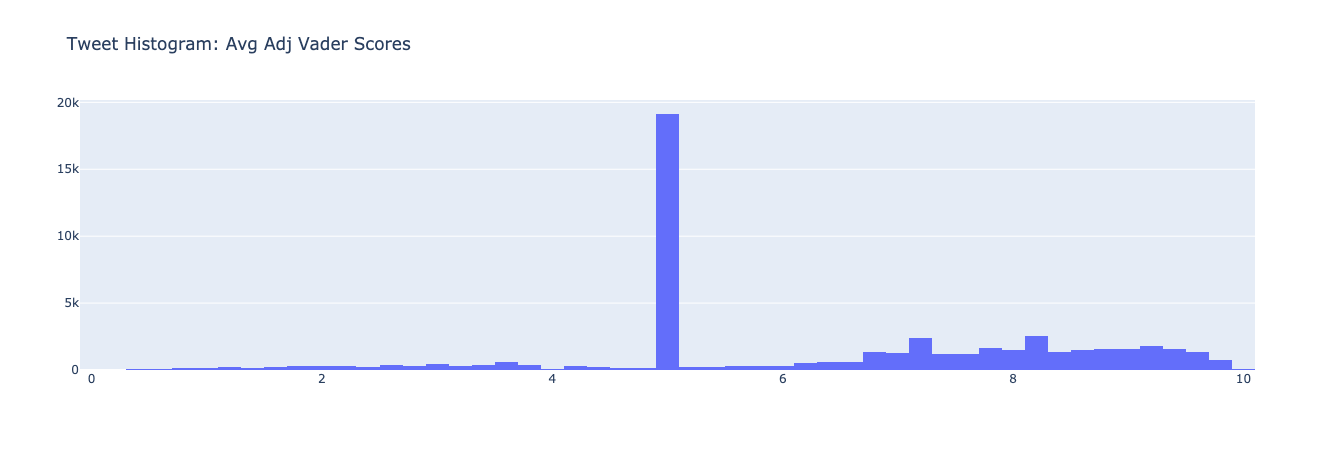

In [19]:
fig = go.Figure({'data':[
    go.Histogram(x=tweets_df['compound_score_adj'], nbinsx=50)
]
                , 'layout': {"title": {"text": "Tweet Histogram: Avg Adj Vader Scores"}}
                }  
               )
fig.show()

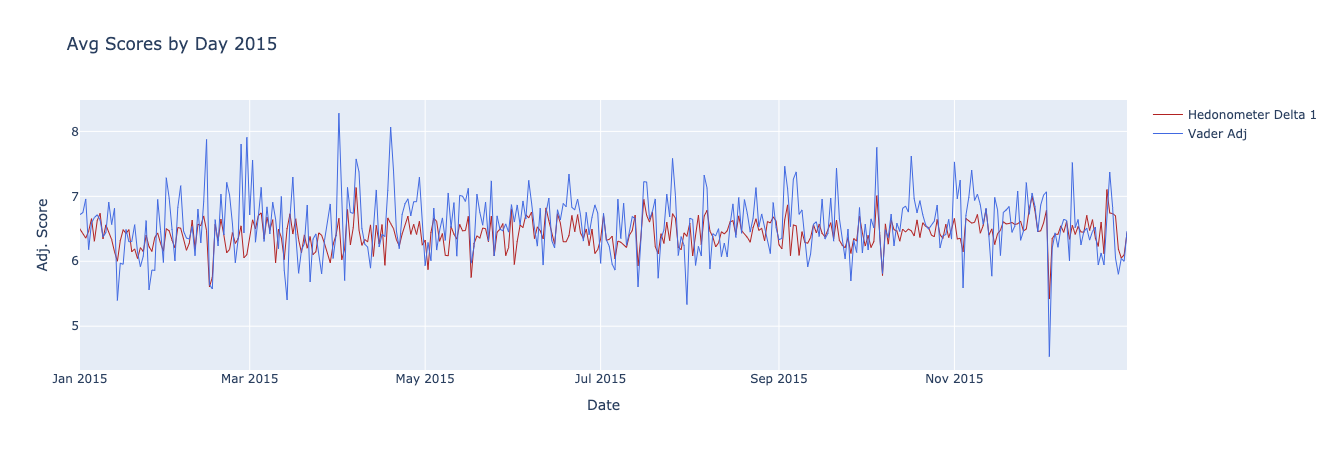

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=by_day_df.index.values
    , y=by_day_df.hedonometer_score
    , name='Hedonometer Delta 1'
   , line=dict(color='firebrick', width=1))
)


fig.add_trace(go.Scatter(
    x=by_day_df.index.values
    , y=by_day_df.compound_score_adj
    , name='Vader Adj'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='Avg Scores by Day 2015',
                   xaxis_title='Date',
                   yaxis_title='Adj. Score')

fig.show()

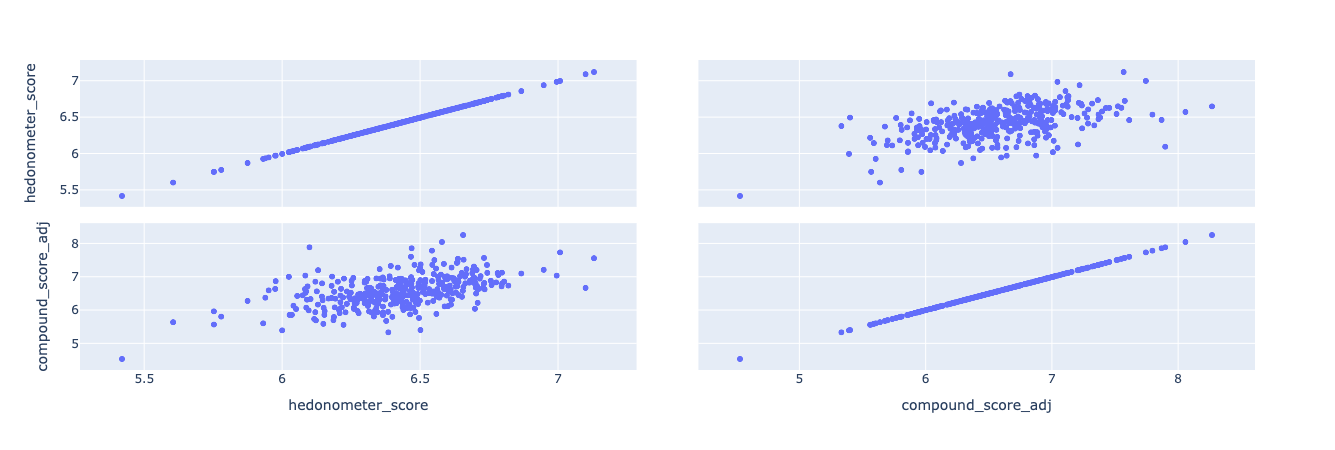

In [21]:
fig = px.scatter_matrix(by_day_df,
    dimensions=['hedonometer_score','compound_score_adj'])
fig.show()

In [22]:
import scipy.stats as stats

stats.pearsonr(by_day_df.compound_score_adj, by_day_df.hedonometer_score)

(0.5142342795057706, 4.997997971948181e-26)

In [23]:


tweets_df.iloc[random.sample(range(100),1)]

author                       content country         date_time  \
23  katyperry  Same https://t.co/98vBUp7BzI     NaN  06/12/2016 09:52   

              id language  latitude  longitude  number_of_likes  \
23  8.060740e+17       en       NaN        NaN             4236   

    number_of_shares                                        vader_score  \
23              1143  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

    compound_score            datetime  hedonometer_word_count  \
23             0.0 2016-06-12 09:52:00                       0   

    hedonometer_total_score  hedonometer_score  compound_score_adj  
23                      0.0                NaN                 5.0

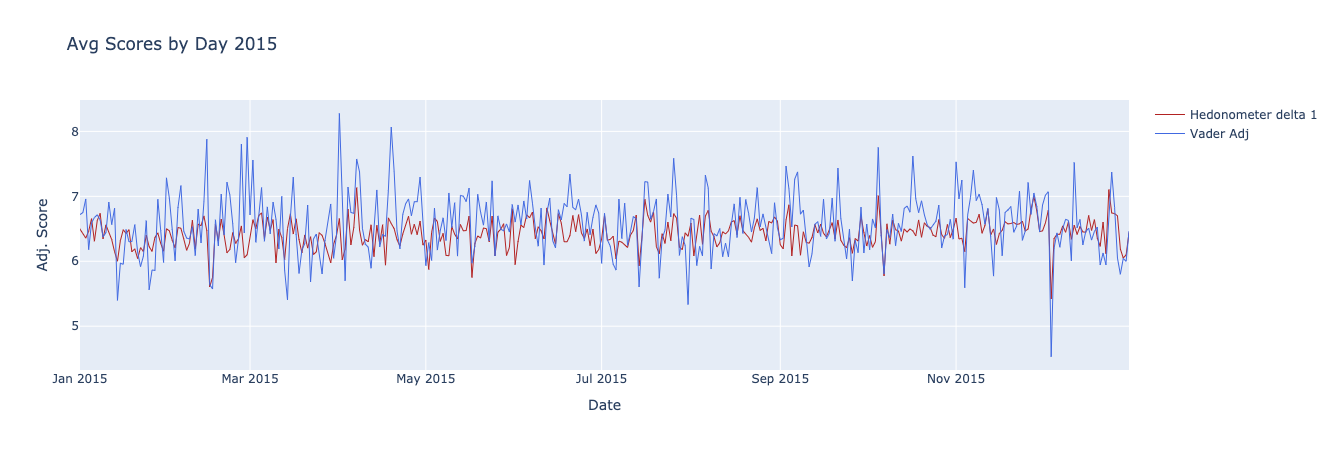

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=by_day_df.index.values
    , y=by_day_df.hedonometer_score
    , name='Hedonometer delta 1'
   , line=dict(color='firebrick', width=1))
)

fig.add_trace(go.Scatter(
    x=by_day_df.index.values
    , y=by_day_df.compound_score_adj
    , name='Vader Adj'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='Avg Scores by Day 2015',
                   xaxis_title='Date',
                   yaxis_title='Adj. Score')

fig.show()

[great guide for using python requests and twitter api](https://benalexkeen.com/interacting-with-the-twitter-api-using-python/)

In [29]:
# api creds
creds = yaml.load(
    open(os.path.expanduser('~/.twitter/creds.yml')), 
    Loader=yaml.FullLoader)

client_key = creds['api-key']
client_secret = creds['api-secret']

import base64

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

In [30]:
import requests

base_url = 'https://api.twitter.com/'
auth_url = '{}oauth2/token'.format(base_url)

auth_headers = {
    'Authorization': 'Basic {}'.format(b64_encoded_key),
    'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
}

auth_data = {
    'grant_type': 'client_credentials'
}

In [31]:
auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)

auth_resp.text

'{"token_type":"bearer","access_token":"AAAAAAAAAAAAAAAAAAAAAJB%2FKQEAAAAABsWmHWYhsQXu%2BwwIq53cvcfmSy8%3DMRiRXUtQ2vPWGbJRyNKtzm6dCgRthdcFGmo4p9ZQbpniVjulyq"}'

In [32]:
access_token = auth_resp.json()['access_token']

In [33]:
# v 1.1 api
search_headers = {
    'Authorization': 'Bearer {}'.format(access_token)    
}

search_params = {
    'q': 'lang:en is:verified',
    'count': 100
}

search_url = '{}1.1/search/tweets.json'.format(base_url)
prem_search_url = '{}1.1/tweets/search/30day/prod.json'.format(base_url)


search_resp = requests.get(search_url, headers=search_headers, params=search_params)
tweet_data = search_resp.json()
print(tweet_data.keys())
len(tweet_data['statuses'])

# random sample of tweets
for obj in random.sample(tweet_data['statuses'],10):
    print(str(obj) + '\n')


dict_keys(['statuses', 'search_metadata'])
{'created_at': 'Sat Dec 12 23:56:05 +0000 2020', 'id': 1337909117105659911, 'id_str': '1337909117105659911', 'text': 'The troops are said to have come across the Bay of Fundy into Maine from Nova Scotia. None of this is verified and… https://t.co/p38ZPh0Itm', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/p38ZPh0Itm', 'expanded_url': 'https://twitter.com/i/web/status/1337909117105659911', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [116, 139]}]}, 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': 1337909116187054080, 'in_reply_to_status_id_str': '1337909116187054080', 'in_reply_to_user_id': 1271946095971782662, 'in_reply_to_user_id_str': '1271946095971782662', 'in_reply_to_screen_name': 'TruthWestCan1', 'user': {'id': 127194609597

In [66]:
# v 2 api
end_time = str((dt.datetime.utcnow() - dt.timedelta(minutes=30)).isoformat()) + 'Z'
start_time = str((dt.datetime.utcnow() - dt.timedelta(days=1, minutes=30)).isoformat()) + 'Z'



search_headers = {
    'Authorization': 'Bearer {}'.format(access_token)    
}

search_params = {
    'query': 'entity: United States -is:retweet',
    'max_results': 100, 
    'end_time': end_time,
    'start_time': start_time,
    
}

search_url = '{}2/tweets/search/recent'.format(base_url)

search_resp = requests.get(search_url, headers=search_headers, params=search_params)
tweet_data = search_resp.json()
print(tweet_data.keys())
print(len(tweet_data['data']))

# random sample of tweets
for obj in random.sample(tweet_data['data'],10):
    print(str(obj) + '\n')


dict_keys(['data', 'meta'])
100
{'id': '1337875157390651397', 'text': '@murray_nyc @DanScavino @realDonaldTrump On a yearly basis... between 40k and 80k Americans die of the flu which we have had a vaccine for for decades and over 200k die worldwide from it... over 100k people in the United states die from cigarettes over 40k die due to automobiles and over 60k die due to alcohol amd all'}

{'id': '1337915448348856323', 'text': 'How Japan Has Almost Eradicated Gun Crime https://t.co/nvYe5SFNTY via @Pocket \nHow....\nThey are all Japanese, truly "One Nation under G-D"\nunlike United States of Diversity of different mental development.'}

{'id': '1337891627906555904', 'text': 'Manutd: Pogba states United commitment on social media https://t.co/jsSQEBN8wt #MUFC'}

{'id': '1337910496402530304', 'text': "@JoeBiden Hiw much money if biden gets back in paris  agreement, will it cost United states.  He's worried about this but not the Americans who are struggling right now."}

{'id': '13378920